In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
from figure_utils import journal_figure, nanmad
import stats as my_stats
from scipy.stats import pearsonr

In [3]:
model_list = ["alexnet_relu", "convnext", "convnext_ssl", "resnet18", "resnet18_robust", "resnet18_ssl", "resnet", "resnet_ssl", "resnet_swsl", "resnetSIN", "resnet152_2", "resnet101", "resnet101_ssl", "resnet_robust_eps1", "resnet_robust_eps3", "inception", "inceptionv1", "vit", "vit_ssl", "vgg16", "vgg16_robust", "densenet", "densenet169", "densenet161", "densenet161_robust", "densenet121", "mobilenet", "mobilenet_v2", "mobilenet_robust", "squeezenet", "cornetS_t0", "cornetS_reg", "cornetRT_t4", "nasnet", "pnasnet", "swin", "swin_ssl", "shufflenet", "shufflenet_robust"]

In [5]:
def compute_correlation(d1, d2):
    rand_r1 = np.random.choice(20, size=20, replace=True)
    rand_r2 = np.random.choice(20, size=20, replace=True)
    corrs_i1 = [
        pearsonr(d1[:,r1], d2[:, r2])[0] for r1, r2 in zip(rand_r1, rand_r2)
    ]
    mean_corr = np.nanmean(corrs_i1)
    std_corr = np.nanstd(corrs_i1)
    return mean_corr, std_corr, corrs_i1

def compute_all_correlations(i1_model_best, i1_model_worst, i1_b, ceiling_b=1.0):
    corr_best_m, corr_best_std, corrs_i1_best = compute_correlation(i1_b, i1_model_best)
    corr_worst_m, corr_worst_std, corrs_i1_worst = compute_correlation(i1_b, i1_model_worst)

    corr_best_m_corr = corr_best_m/np.sqrt(ceiling_b)
    corr_worst_m_corr = corr_worst_m/np.sqrt(ceiling_b)

    return corr_best_m_corr, corr_worst_m_corr, corrs_i1_best, corrs_i1_worst

In [7]:
model = "resnet"
sample_size_best_match_ = {}
#find the closest sample size to match i1_bad
for monkey in ["m1", "m2"]:
    
    i1_bad = np.load(f'./results_behavior/{model}/{monkey}/i1_bad.npy')

    best_match = None
    for sample_size in range(200, 300, 20):
        i1_good = np.load(f'./results_behavior/{model}/{monkey}/i1_good_{sample_size}.npy')
        if best_match is None or abs(np.mean(i1_good) - np.mean(i1_bad)) < abs(np.mean(best_match) - np.mean(i1_bad)):
            sample_size_best_match = sample_size
            best_match = i1_good
    
    sample_size_best_match_[monkey] = sample_size_best_match


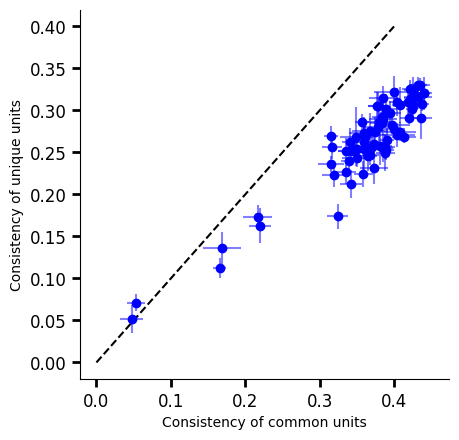

In [8]:

all_corrs_i1_best = []
all_corrs_i1_worst = []

for model2 in model_list:
    if "cornet" not in model2:
        for monkey in ["m1", "m2"]:
            i1_good = np.load(f'./results_behavior/{model}/{monkey}/i1_good_{sample_size_best_match_[monkey]}.npy').mean(axis=0)
            i1_bad = np.load(f'./results_behavior/{model}/{monkey}/i1_bad.npy')

            i1_behavior = np.load(f'./results_behavior/{model2}/behavior_i1.npy')

            corr_best, corr_worst, corrs_i1_best, corrs_i1_worst  = compute_all_correlations(i1_good, i1_bad, i1_behavior)
            
            color = "blue"
            plt.scatter(np.nanmean(corrs_i1_best), np.nanmean(corrs_i1_worst), label=model, color=color, zorder=5)
            plt.errorbar(np.nanmean(corrs_i1_best), np.nanmean(corrs_i1_worst), 
                        xerr=nanmad(corrs_i1_best), yerr=nanmad(corrs_i1_worst), color=color, alpha=0.5, zorder=0)
            
            all_corrs_i1_best.append(np.nanmean(corrs_i1_best))
            all_corrs_i1_worst.append(np.nanmean(corrs_i1_worst))

plt.plot([0, 0.4], [0, 0.4], color='black', linestyle='--')
plt.xlabel("Consistency of common units")
plt.ylabel("Consistency of unique units")
journal_figure()


In [9]:
my_stats.print_paired_test(all_corrs_i1_best, all_corrs_i1_worst)

z = 3.0, p < 0.001


np.float64(1.8818774510349353e-13)

In [11]:
np.median(all_corrs_i1_best), nanmad(all_corrs_i1_best)

(np.float64(0.37842669203826895), np.float64(0.028921066102983922))

In [12]:
np.median(all_corrs_i1_worst), nanmad(all_corrs_i1_worst)

(np.float64(0.26905432248347905), np.float64(0.023421161910913715))

In [13]:
def compute_correlation_monkeys(d1, d2):
    rand_r1 = np.random.choice(20, size=20, replace=True)
    rand_r2 = np.random.choice(20, size=20, replace=True)
    corrs_i1 = [
        pearsonr(d1[:], d2[:, r2])[0]
        for r1, r2 in zip(rand_r1, rand_r2)
    ]
    mean_corr = np.nanmean(corrs_i1)
    std_corr = np.nanmean(corrs_i1)/np.sqrt(1320)

    return mean_corr, std_corr, corrs_i1

def compute_all_correlations(i1_model_best, i1_model_worst, i1_b, ceiling_b=1.0, ceiling_db=1.0, ceiling_dw=1.0): #, ceiling_b):
    corr_best_m, corr_best_std, corrs_i1_best = compute_correlation_monkeys(i1_b, i1_model_best)
    corr_worst_m, corr_worst_std, corrs_i1_worst = compute_correlation_monkeys(i1_b, i1_model_worst)

    corr_best_m_corr = corr_best_m/np.sqrt(ceiling_b*ceiling_db)
    corr_worst_m_corr = corr_worst_m/np.sqrt(ceiling_b*ceiling_dw)

    return corr_best_m_corr, corr_worst_m_corr, corrs_i1_best, corrs_i1_worst

In [14]:
colors=["#DC5069", "#836996", "#F8D45C", "#70BDA5"]

In [ ]:
b_m2 = np.load("./behavior/i1_m2.npy")
b_m1 = np.load("./behavior/i1_m1.npy")
b_m3 = np.load("./behavior/i1_m3.npy")
b_human = np.load("./behavior/i1_human.npy")


dict_bi1={  
    "m2": b_m2,  
    "m1": b_m1,  
    "m3": b_m3,  
    "human": b_human,  
    }  
  
ceiling_b_m1 = 0.8724219
ceiling_b_m2 = 0.868336
ceiling_b_m3 = 0.7774685
ceiling_b_human = 0.892218

dict_bc={  
    "m2": ceiling_b_m2,  
    "m1": ceiling_b_m1,  
    "m3": ceiling_b_m3,  
    "human": ceiling_b_human,  
    }  



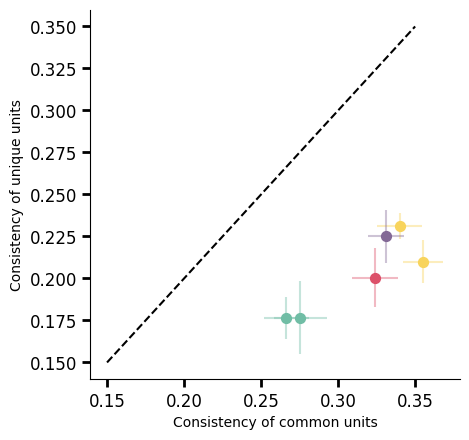

In [40]:
commons = []
uniques = []
for monkey in ["m1", "m2"]:
    
    for model in ["resnet"]:
        i1_good = np.load(f'./results_behavior/{model}/{monkey}/i1_good_{sample_size_best_match_[monkey]}.npy').mean(axis=0)
        i1_bad = np.load(f'./results_behavior/{model}/{monkey}/i1_bad.npy')
        corrs = {}
        corrs_g = []
        corrs_b = []
        i=0
        for key, item in dict_bi1.items():
            if monkey == key:
                i+=1
                continue
            corr_best_corr, corr_worst_corr, corrs_i1_best, corrs_i1_worst = compute_all_correlations(i1_good, i1_bad, item, dict_bc[key], 1.0, 1.0)
            corrs[key] = {}
            corrs[key]["good"] = np.array(corrs_i1_best)
            corrs[key]["bad"] = np.array(corrs_i1_worst)

            corrs_g.append(corrs[key]["good"].mean())
            corrs_b.append(corrs[key]["bad"].mean())
            commons.append(corrs[key]["good"].mean())
            uniques.append(corrs[key]["bad"].mean())

            plt.scatter(corrs[key]["good"].mean(), corrs[key]["bad"].mean(), 50, marker="o", color=colors[i])
            plt.errorbar(corrs[key]["good"].mean(), corrs[key]["bad"].mean(), xerr=corrs[key]["good"].std(), yerr=corrs[key]["bad"].std(), alpha=0.4, color=colors[i])        

            i+=1


plt.plot([0.15, 0.35], [0.15, 0.35], color="black", linestyle="--")
plt.xlabel("Consistency of common units")
plt.ylabel("Consistency of unique units")
journal_figure()
plt.show()           

In [42]:
my_stats.print_paired_test(commons, uniques)

t(5) = 13.979525707318915, p < 0.001


np.float64(3.3676081205025215e-05)

In [ ]:
i1_best_m = np.load(f"./behavior/i1s_common_m1_18.npy").mean(axis=0)
i1_best_n = np.load(f"./behavior/i1s_common_m2_18.npy").mean(axis=0)

In [ ]:
ceilings_m1_best = np.load('./behavior/ceiling_i1_m1_common.npy')
ceilings_m1_worst = np.load('./behavior/ceiling_i1_m1_unique.npy')
ceilings_m2_best = np.load('./behavior/ceiling_i1_m2_common.npy')
ceilings_m2_worst = np.load('./behavior/ceiling_i1_m2_unique.npy')

In [ ]:
i1_worst_m = np.load("./behavior/i1s_unique_m1.npy")
i1_worst_n = np.load("./behavior/i1s_unique_m2.npy")

In [38]:
corrs_m1 = {}
for key, item in dict_bi1.items():
    corr_best_m_corr, corr_worst_m_corr, corrs_i1_best_m, corrs_i1_worst_m = compute_all_correlations(i1_best_m, i1_worst_m, item, dict_bc[key], ceilings_m1_best, ceilings_m1_worst)
    corrs_m1[key] = {}
    corrs_m1[key]["good"] = np.array(corrs_i1_best_m)
    corrs_m1[key]["bad"] = np.array(corrs_i1_worst_m)

corrs_m2 = {}
for key, item in dict_bi1.items():
    corr_best_n_corr, corr_worst_n_corr, corrs_i1_best_n, corrs_i1_worst_n = compute_all_correlations(i1_best_n, i1_worst_n, item, dict_bc[key], ceilings_m2_best, ceilings_m2_worst)
    corrs_m2[key] = {}
    corrs_m2[key]["good"] = np.array(corrs_i1_best_n)
    corrs_m2[key]["bad"] = np.array(corrs_i1_worst_n)

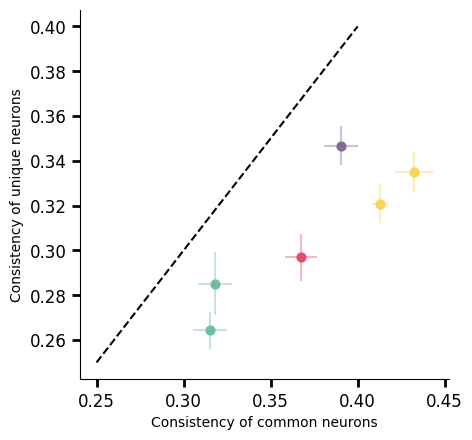

In [43]:
i=0
commons = []
uniques = []
for key, item in dict_bi1.items():
    if key == "m2":
        plt.scatter(corrs_m2[key]["good"].mean(), corrs_m2[key]["bad"].mean(), 40, marker="X" if key=="m1" else "o", color=colors[i])
        plt.errorbar(corrs_m2[key]["good"].mean(), corrs_m2[key]["bad"].mean(), xerr=corrs_m2[key]["good"].std(), yerr=corrs_m2[key]["bad"].std(), alpha=0.4, color=colors[i])
    elif key == "m1":
        plt.scatter(corrs_m1[key]["good"].mean(), corrs_m1[key]["bad"].mean(), 40, marker="X" if key=="m2" else "o", color=colors[i])
        plt.errorbar(corrs_m1[key]["good"].mean(), corrs_m1[key]["bad"].mean(), xerr=corrs_m1[key]["good"].std(), yerr=corrs_m1[key]["bad"].std(), alpha=0.4, color=colors[i])
    else:
        plt.scatter(corrs_m1[key]["good"].mean(), corrs_m1[key]["bad"].mean(), 40, marker="X" if key=="m2" else "o", color=colors[i])
        plt.scatter(corrs_m2[key]["good"].mean(), corrs_m2[key]["bad"].mean(), 40, marker="X" if key=="m1" else "o", color=colors[i])
        plt.errorbar(corrs_m1[key]["good"].mean(), corrs_m1[key]["bad"].mean(), xerr=corrs_m1[key]["good"].std(), yerr=corrs_m1[key]["bad"].std(), alpha=0.4, color=colors[i])
        plt.errorbar(corrs_m2[key]["good"].mean(), corrs_m2[key]["bad"].mean(), xerr=corrs_m2[key]["good"].std(), yerr=corrs_m2[key]["bad"].std(), alpha=0.4, color=colors[i])
    i+=1

    commons.append(corrs_m1[key]["good"].mean())
    uniques.append(corrs_m1[key]["bad"].mean())
    commons.append(corrs_m2[key]["good"].mean())
    uniques.append(corrs_m2[key]["bad"].mean())
plt.plot([0.25, 0.4], [0.25, 0.4], color="black", linestyle="--")
plt.xlabel("Consistency of common neurons")
plt.ylabel("Consistency of unique neurons")
journal_figure()
plt.show()

In [44]:
my_stats.print_paired_test(commons, uniques)

t(7) = 8.287443740638624, p < 0.001


np.float64(7.270570055015832e-05)